In [49]:
import numpy as np
import time
import json
import matplotlib.pyplot as plt
from itertools import product
import torch
from torch.autograd import Variable
from wvaegan_gp.model_vector import Encoder, Decoder, Discriminator

In [50]:
# パラメータ
OUTPUT_DIR = 'wvaegan_gp/results'
DATA_PATH = '../motor_dataset_20221018st'
N_CLASSES = 1
COORD_SIZE = 932  # 座標の数
LATENT_DIM = 2
done_epoch = 50000

In [43]:
cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
coords_shape = (1, COORD_SIZE)

rng = np.random.default_rng(0)

torques_npz = np.load(f"{DATA_PATH}/labels.npz")
coords_npz = np.load(f"{DATA_PATH}/coords.npz")
torques = torques_npz[torques_npz.files[0]]
torque_mean = torques_npz[torques_npz.files[2]]
torque_std = torques_npz[torques_npz.files[3]]
coords = coords_npz[coords_npz.files[0]]
coord_mean = coords_npz[coords_npz.files[1]]
coord_std = coords_npz[coords_npz.files[2]]

max_torque = torques.max()
min_torque = torques.min()

In [5]:
encoder = Encoder(LATENT_DIM, COORD_SIZE)
decoder = Decoder(LATENT_DIM, COORD_SIZE)
discriminator = Discriminator(COORD_SIZE)

E_PATH = f"{OUTPUT_DIR}/encoder_params_dim{LATENT_DIM}_vector_{done_epoch}"
G_PATH = f"{OUTPUT_DIR}/decoder_params_dim{LATENT_DIM}_vector_{done_epoch}"
D_PATH = f"{OUTPUT_DIR}/discriminator_params_dim{LATENT_DIM}_vector_{done_epoch}"

encoder.load_state_dict(torch.load(E_PATH, map_location=torch.device('cpu')))
encoder.eval()

decoder.load_state_dict(torch.load(G_PATH, map_location=torch.device('cpu')))
decoder.eval()

discriminator.load_state_dict(torch.load(D_PATH, map_location=torch.device('cpu')))
discriminator.eval()

if cuda:
    print("use GPU")
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()

use GPU


In [76]:
max_torque = 0.180
min_torque = 0.010
step_torque = 0.010

max_latent = 1.00
min_latent = -1.00
step_latent = 0.20

torque_array = np.arange(min_torque, max_torque+step_torque, step_torque)

# 潜在変数が2のとき
latent_array_temp = np.arange(min_latent, max_latent+step_latent, step_latent)

latent_array = []
for p in product(latent_array_temp, latent_array_temp):
    latent_array.append(list(p))

latent_array = np.array(latent_array)

In [77]:
def make_json(x_array, y_array):
    output_json = []
    for x, y in zip(x_array, y_array):
        output_json.append({'x': x, 'y': y})
    return output_json

In [83]:
coords_json = {}
for torque in torque_array:

    torque_idx = f'{torque:.3f}'
    coords_json[torque_idx] = {}

    torque_standardized = (torque-torque_mean) / torque_std
    torque_standardized = torque_standardized.reshape([1, 1])
    torque_standardized = Variable(FloatTensor(torque_standardized))

    z = Variable(FloatTensor(rng.standard_normal(size=(1, COORD_SIZE))))
    mus, log_variances = encoder(z, torque_standardized)
    variances = torch.exp(log_variances * 0.5)

    for latent in latent_array:
        
        latent_idx_first = f'{latent[0]:.2f}'
        if latent_idx_first =='-0.00':
            latent_idx_first = '0.00'
        latent_idx_second = f'{latent[1]:.2f}'
        if latent_idx_second =='-0.00':
            latent_idx_second = '0.00'

        coords_json[torque_idx].setdefault(latent_idx_first, {})
        coords_json[torque_idx][latent_idx_first][latent_idx_second] = {}
        latent = latent.reshape([1, -1])
        Z_p = Variable(FloatTensor(latent))
        Z = Z_p * variances + mus
        en_coords = decoder(Z, torque_standardized).cpu().detach().numpy()[0]
        coords = en_coords*coord_std+coord_mean  # 標準化を戻す

        coords_json[torque_idx][latent_idx_first][latent_idx_second]['magnet'] = make_json(coords[:136], coords[136:272])  # 磁石
        coords_json[torque_idx][latent_idx_first][latent_idx_second]['holl'] = make_json(coords[272:272+184], coords[272+184:272+368])  # 穴
        # coords_json[torque_idx][latent_idx_first][latent_idx_second]['outline'] = make_json(coords[272+368:272+368+146], coords[272+368+146:])  # 外枠

In [85]:
with open('../app/frontend/src/assets/coords.json', 'w') as f:
    json.dump(coords_json, f)

In [73]:
def save_coords_motor(gen_coords, labels, path):
    data_size = gen_coords.shape[0]
    fig, ax = plt.subplots(4,min(5, data_size//4), figsize=(12, 8), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.4)
    torque_idx = np.argsort(labels.flatten())
    for i in range(min(20, data_size)):
        idx = torque_idx[i]

        coord = gen_coords[idx]
        label = labels[idx][0]

        ax[i%4, i//4].plot(coord[:136], coord[136:272])  # 磁石
        ax[i%4, i//4].plot(coord[272:272+184], coord[272+184:272+368])  # 穴
        # ax[i%4, i//4].plot(coord[272+368:272+368+146], coord[272+368+146:])  # 外枠

        torque = round(label.item(), 3)
        title = f'torque={torque}'
        ax[i%4, i//4].set_title(title)
    
    fig.savefig(path)
    plt.close()

In [74]:
max_torque = 0.180
min_torque = 0.010
step_torque = 0.010

max_latent = 1.00
min_latent = -1.00
step_latent = 0.20

labels = np.arange(min_torque, max_torque+step_torque, step_torque).reshape([-1, 1])
labels = (labels - torque_mean) / torque_std

# 潜在変数が2のとき
latent_array_temp = np.arange(min_latent, max_latent+step_latent, step_latent)

latent_array = []
for p in product(latent_array_temp, latent_array_temp):
    latent_array.append(list(p))

latent_array = np.array(latent_array)

IndexError: index 4 is out of bounds for axis 1 with size 4

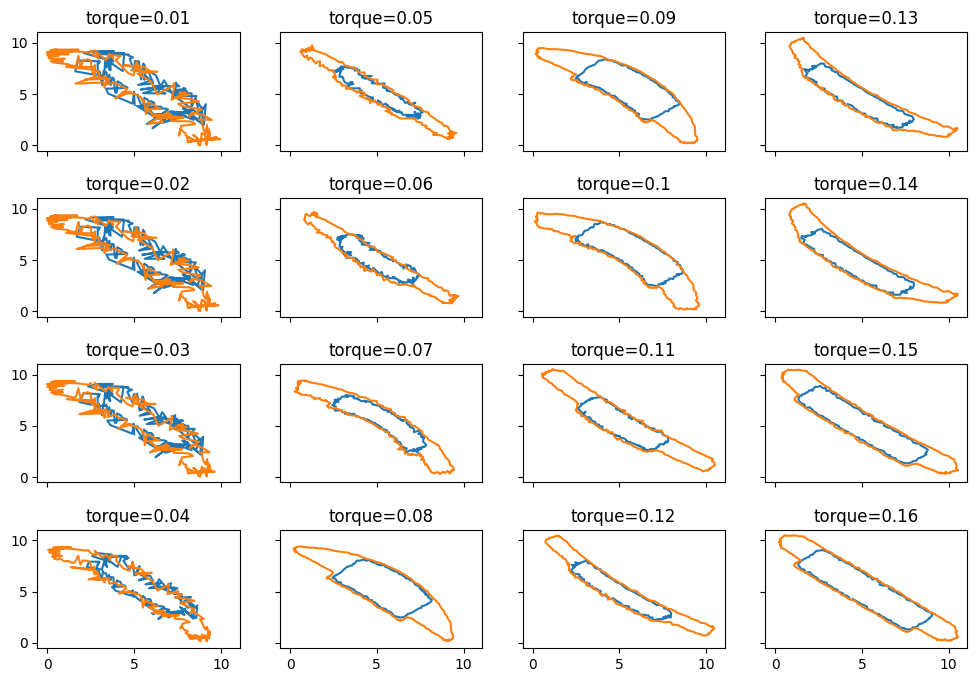

In [75]:
data_num = len(labels)
labels = Variable(FloatTensor(labels))

z = Variable(FloatTensor(rng.standard_normal(size=(data_num, coords_shape[1]))))
#データセットをencode
mus, log_variances = encoder(z, labels)
variances = torch.exp(log_variances * 0.5)
Z_p = Variable(FloatTensor(latent_array[-data_num:]))
Z = Z_p * variances + mus

en_coords = decoder(Z, labels).cpu().detach().numpy()

labels = labels.cpu()
labels = labels.detach().numpy()
# 標準化を戻す
en_coords_destandardized = en_coords*coord_std+coord_mean
labels_destandardized = labels * torque_std + torque_mean

save_coords_motor(en_coords_destandardized, labels_destandardized, "b")

In [60]:
data_num = 20
labels = rng.uniform(min_torque, max_torque, size=(data_num, 1))
labels = Variable(FloatTensor(labels))

z = Variable(FloatTensor(rng.standard_normal(size=(data_num, coords_shape[1]))))
#データセットをencode
mus, log_variances = encoder(z, labels)
variances = torch.exp(log_variances * 0.5)
Z_p = Variable(FloatTensor(rng.standard_normal(size=(data_num, LATENT_DIM))))
Z = Z_p * variances + mus

en_coords = decoder(Z, labels).cpu().detach().numpy()

labels = labels.cpu()
labels = labels.detach().numpy()
# 標準化を戻す
en_coords_destandardized = en_coords*coord_std+coord_mean
labels_destandardized = labels * torque_std + torque_mean

save_coords_motor(en_coords_destandardized, labels_destandardized, "a")

In [61]:
labels.shape

(20, 1)